# Rust Unstable Feature Analysis (v3)

This notebook summarizes the sampling pipeline and visualizes the CSV outputs generated by `analyze_features.py` for `features_head_v3.db`.

What you need:
- Python 3.9+
- `pandas`, `matplotlib`, `seaborn` (install with `pip install pandas matplotlib seaborn` if missing)
- CSVs in `analysis_outputs/`: `feature_head_summary.csv`, `feature_history_summary.csv`, `feature_lifetimes.csv`, `category_summary.csv`
- Optional: raw tables in `features_head_v3.db` for deeper joins.

Sampling background (v3):
- Two-layer sampling from crates.io dump:
  - **Core stratum**: top N by reverse dependencies (N=300) + optional core list.
  - **Non-core stratum**: filter by downloads >=100 and latest year >=2015, then stratify by (top_category, popularity_band) using p50/p90 downloads.
- Only GitHub repos are kept; duplicate owner/repo collapsed (pick higher revdeps/downloads).
- Target size: 1500 repos; final unique GitHub repos: 1500.

This notebook first re-summarizes sampling outputs (ratios by core/non-core, categories), then visualizes nightly feature usage.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sqlite3
from datetime import datetime

# Optional: load sampled CSV to recompute sampling stats
SAMPLE_CSV = Path("sampled_crates_v3.csv")
DB_PATH = Path("features_head_v3.db")

sns.set_theme(style="whitegrid")
BASE = Path("analysis_outputs")

head_df = pd.read_csv(BASE / "feature_head_summary.csv")
hist_df = pd.read_csv(BASE / "feature_history_summary.csv")
life_df = pd.read_csv(BASE / "feature_lifetimes.csv")
cat_df = pd.read_csv(BASE / "category_summary.csv")

sample_df = None
if SAMPLE_CSV.exists():
    sample_df = pd.read_csv(SAMPLE_CSV)

conn = None
if DB_PATH.exists():
    conn = sqlite3.connect(DB_PATH)


head_df.head(), hist_df.head(), life_df.head(), cat_df.head()

(      feature_name  head_repo_count
 0          doc_cfg              137
 1             test               84
 2     doc_auto_cfg               24
 3    allocator_api               12
 4  core_intrinsics                8,
    feature_name  ever_repo_count
 0          test              155
 1       doc_cfg              131
 2  doc_auto_cfg               71
 3        plugin               69
 4          core               68,
              feature_name  num_repos  num_still_present  num_retired  \
 0                   Serde          2                  0            2   
 1                _preview          1                  0            1   
 2                       a          2                  0            2   
 3  aarch64_target_feature          1                  0            1   
 4            abi_thiscall          1                  1            0   
 
          min_first_seen_date        max_first_seen_date  \
 0  2017-10-22T22:46:17+00:00  2017-10-22T22:57:00+00:00   
 1  2018-07-

## 1) Sampling recap
- Core vs non-core composition
- Top categories by sample size
- HEAD vs EVER nightly ratios for core/non-core

Sample size: 1500 (core=300, non-core=1200)


/var/folders/ys/l5n5p6z52jqfj7qhnknsgwhh0000gn/T/ipykernel_14589/2878694226.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_cats, x="count", y="top_category", ax=axes[0], palette="viridis")
/var/folders/ys/l5n5p6z52jqfj7qhnknsgwhh0000gn/T/ipykernel_14589/2878694226.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cat_df_sorted, x="head_nightly_ratio", y="category", ax=axes[1], palette="rocket")


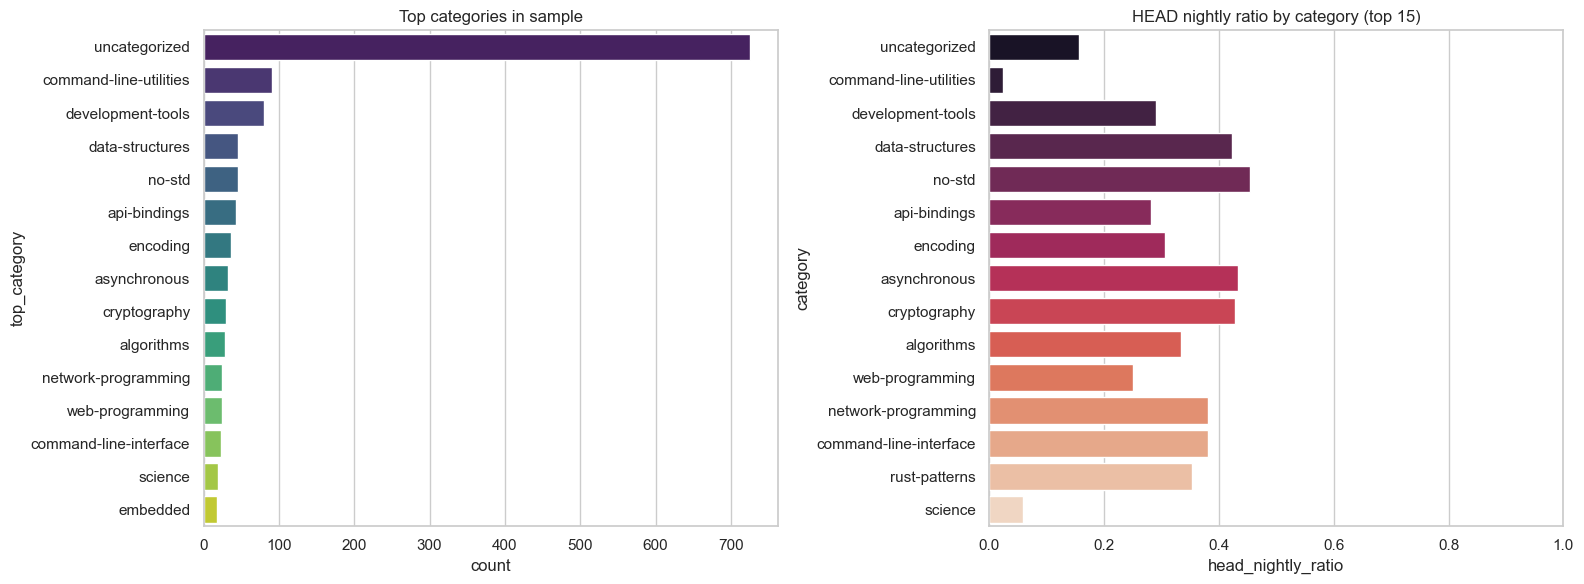

In [2]:
if sample_df is not None:
    # Basic counts
    total = len(sample_df)
    core = sample_df[sample_df["is_core"] == 1]
    noncore = sample_df[sample_df["is_core"] == 0]
    print(f"Sample size: {total} (core={len(core)}, non-core={len(noncore)})")

    # Category sizes
    top_cats = sample_df["top_category"].value_counts().head(15).reset_index()
    top_cats.columns = ["top_category", "count"]

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    sns.barplot(data=top_cats, x="count", y="top_category", ax=axes[0], palette="viridis")
    axes[0].set_title("Top categories in sample")

    # Core vs non-core ratio of HEAD/EVER nightly (join with cat_df ratios is coarse; here use cat_df aggregated)
    cat_df_sorted = cat_df.sort_values("total_repos", ascending=False).head(15)
    sns.barplot(data=cat_df_sorted, x="head_nightly_ratio", y="category", ax=axes[1], palette="rocket")
    axes[1].set_title("HEAD nightly ratio by category (top 15)")
    axes[1].set_xlim(0, 1)

    plt.tight_layout()
    plt.show()
else:
    print("sampled_crates_v3.csv not found; skip sampling recap.")

## 2) Feature usage overview
- Distribution of HEAD vs EVER usage counts per feature
- Identify dominant gates

/var/folders/ys/l5n5p6z52jqfj7qhnknsgwhh0000gn/T/ipykernel_14589/2310721705.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_long, x="avg_lifetime_days", y="feature_name", ax=axes[1], palette="magma")


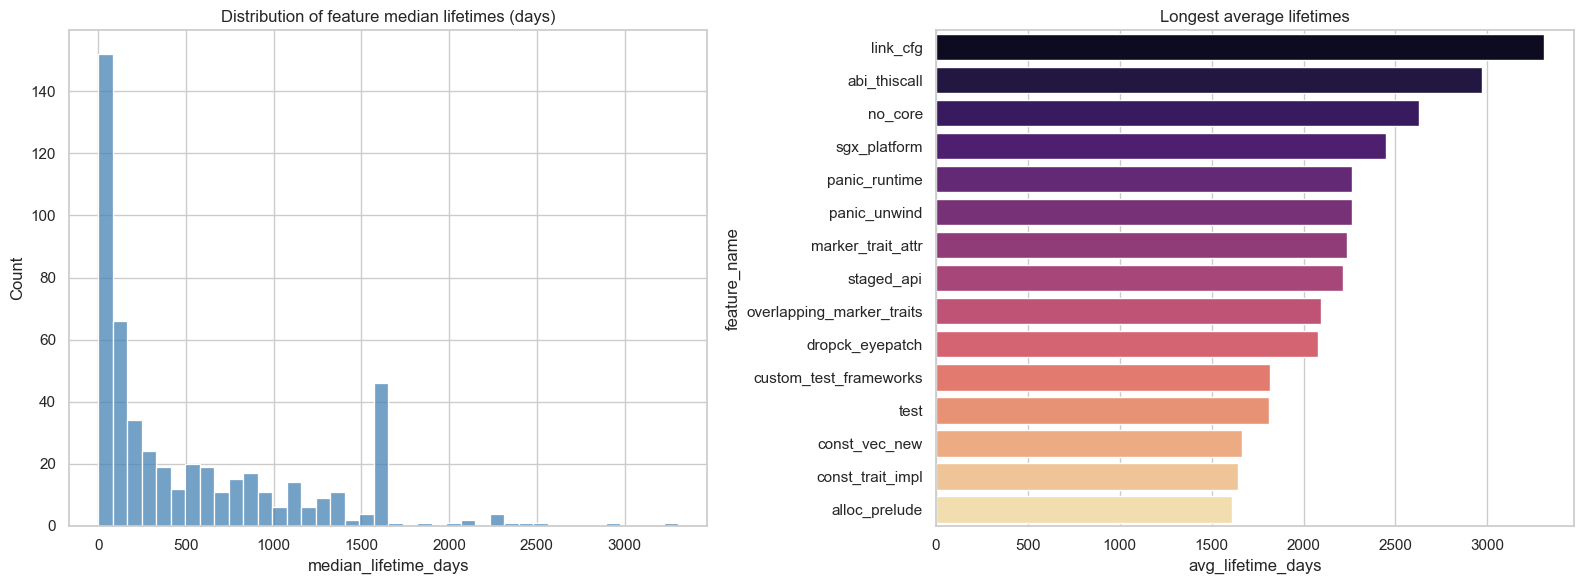

In [3]:
life_df["avg_lifetime_days"] = pd.to_numeric(life_df["avg_lifetime_days"], errors="coerce")
life_df["median_lifetime_days"] = pd.to_numeric(life_df["median_lifetime_days"], errors="coerce")
life_df["num_repos"] = pd.to_numeric(life_df["num_repos"], errors="coerce")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.histplot(life_df["median_lifetime_days"].dropna(), bins=40, ax=axes[0], color="steelblue")
axes[0].set_title("Distribution of feature median lifetimes (days)")

top_long = life_df.dropna(subset=["avg_lifetime_days"]).nlargest(15, "avg_lifetime_days")
sns.barplot(data=top_long, x="avg_lifetime_days", y="feature_name", ax=axes[1], palette="magma")
axes[1].set_title("Longest average lifetimes")
plt.tight_layout()
plt.show()

## 4) Retention vs adoption
- Still-present ratio = num_still_present / num_repos
- Compare with coverage to spot "sticky" gates


/var/folders/ys/l5n5p6z52jqfj7qhnknsgwhh0000gn/T/ipykernel_14589/2288233386.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_ratio, x="still_ratio", y="feature_name", palette="crest")


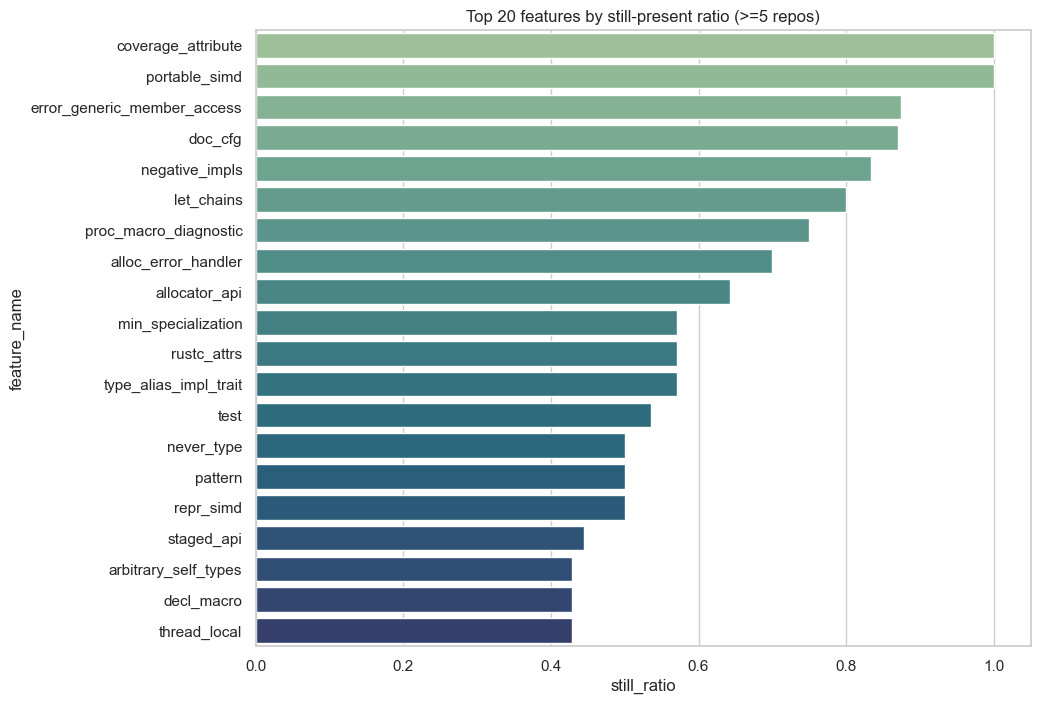

In [4]:
life_df["still_ratio"] = life_df["num_still_present"] / life_df["num_repos"]
top_ratio = life_df[life_df["num_repos"] >= 5].nlargest(20, "still_ratio")

plt.figure(figsize=(10, 8))
sns.barplot(data=top_ratio, x="still_ratio", y="feature_name", palette="crest")
plt.title("Top 20 features by still-present ratio (>=5 repos)")
plt.xlim(0, 1.05)
plt.show()

## 5) Category perspective
- Compare per-category nightly reliance on HEAD vs EVER


/var/folders/ys/l5n5p6z52jqfj7qhnknsgwhh0000gn/T/ipykernel_14589/1371848552.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cat_top, x="head_nightly_ratio", y="category", ax=axes[0], palette="rocket")
/var/folders/ys/l5n5p6z52jqfj7qhnknsgwhh0000gn/T/ipykernel_14589/1371848552.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cat_top, x="ever_nightly_ratio", y="category", ax=axes[1], palette="mako")


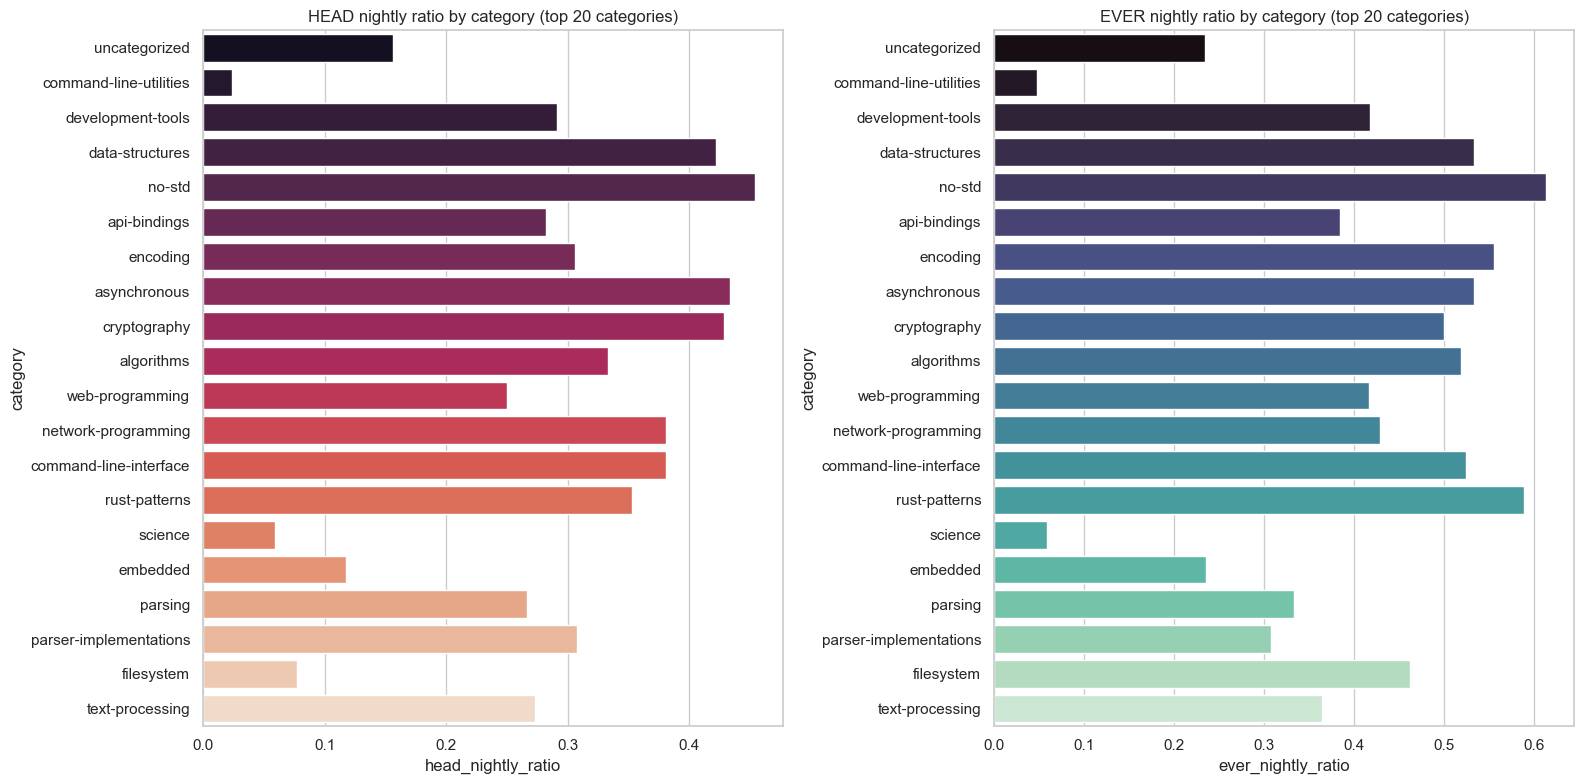

In [5]:
cat_df["head_nightly_ratio"] = pd.to_numeric(cat_df["head_nightly_ratio"], errors="coerce")
cat_df["ever_nightly_ratio"] = pd.to_numeric(cat_df["ever_nightly_ratio"], errors="coerce")
cat_top = cat_df.sort_values("total_repos", ascending=False).head(20)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))
sns.barplot(data=cat_top, x="head_nightly_ratio", y="category", ax=axes[0], palette="rocket")
axes[0].set_title("HEAD nightly ratio by category (top 20 categories)")
sns.barplot(data=cat_top, x="ever_nightly_ratio", y="category", ax=axes[1], palette="mako")
axes[1].set_title("EVER nightly ratio by category (top 20 categories)")
plt.tight_layout()
plt.show()

## 6) Next steps (fill in as you iterate)
- Join with a feature→stable_date table to plot adoption curves vs stabilization.
- Compute time-to-stable intervals: (first substantial adoption) → (stable date).
- Segment by core/non-core, popularity bands, downloads/revdeps quantiles.
- Highlight currently unstable gates with high still-present ratios and long lifetimes.

## 7) Stable timeline for selected gates
Hard-code known stable dates (approx; use release notes/unstable book). Dates as ISO-8601; missing → still unstable.

In [6]:
# Known stabilization dates (rough, keep in sync with Rust release notes)
stable_map = {
    "doc_cfg": "1.54.0|2021-07-29",
    "doc_auto_cfg": "1.75.0|2024-01-18",
    "never_type": "1.41.0|2020-01-30",
    "allocator_api": None,   # still unstable
    "specialization": None,  # still unstable
    "plugin": "1.29.0|2018-07-19",  # removed/retired, was unstable
    "test": "1.0.0|2015-05-15",   # public via libtest but feature gate retired
}

def parse_stable_date(s):
    if not s:
        return None
    if "|" in s:
        _, date = s.split("|", 1)
    else:
        date = s
    try:
        return datetime.fromisoformat(date)
    except Exception:
        return None

stable_dates = {k: parse_stable_date(v) for k, v in stable_map.items()}
stable_dates

{'doc_cfg': datetime.datetime(2021, 7, 29, 0, 0),
 'doc_auto_cfg': datetime.datetime(2024, 1, 18, 0, 0),
 'never_type': datetime.datetime(2020, 1, 30, 0, 0),
 'allocator_api': None,
 'specialization': None,
 'plugin': datetime.datetime(2018, 7, 19, 0, 0),
 'test': datetime.datetime(2015, 5, 15, 0, 0)}

## 8) Adoption curves for selected gates
- Pull from `repo_feature_history` in DB.
- Count active repos per quarter (first_seen_date bucket) to see adoption over time.

/var/folders/ys/l5n5p6z52jqfj7qhnknsgwhh0000gn/T/ipykernel_14589/2711643946.py:23: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  hist_sel["first_quarter"] = hist_sel["first_seen_date"].dt.to_period("Q")


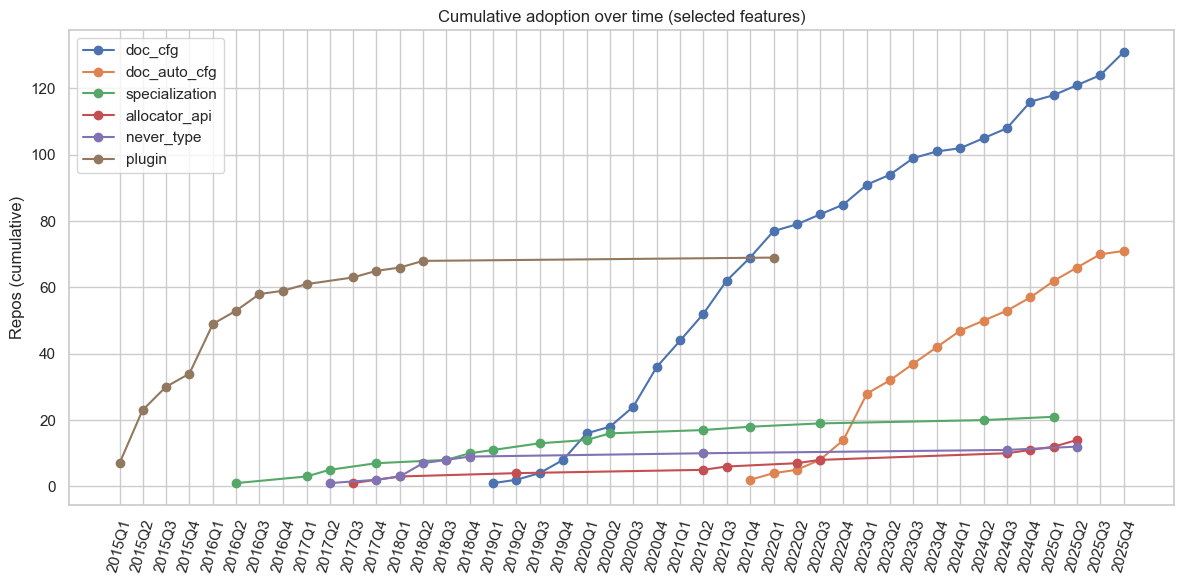

In [7]:
import pandas as pd

def load_history(conn, features):
    qmarks = ",".join(["?"]*len(features))
    df = pd.read_sql_query(
        f"""
        SELECT feature_name, first_seen_date, last_seen_date, still_present, key
        FROM repo_feature_history
        WHERE feature_name IN ({qmarks})
        """,
        conn,
        params=features,
    )
    df["first_seen_date"] = pd.to_datetime(df["first_seen_date"], errors="coerce")
    df["last_seen_date"] = pd.to_datetime(df["last_seen_date"], errors="coerce")
    return df

selected = ["doc_cfg", "doc_auto_cfg", "specialization", "allocator_api", "never_type", "plugin"]

if conn is not None:
    hist_sel = load_history(conn, selected)
    if not hist_sel.empty:
        hist_sel["first_quarter"] = hist_sel["first_seen_date"].dt.to_period("Q")
        adoption = (hist_sel.groupby(["feature_name", "first_quarter"])  # count repos first adopting per quarter
                             .size()
                             .reset_index(name="count"))
        adoption = adoption.sort_values("first_quarter")
        all_quarters = adoption["first_quarter"].dropna().sort_values().unique()
        plt.figure(figsize=(12,6))
        for feat in selected:
            sub = adoption[adoption["feature_name"] == feat]
            if sub.empty:
                continue
            # cumulative adoption over time
            sub = sub.sort_values("first_quarter")
            sub["cum"] = sub["count"].cumsum()
            x = sub["first_quarter"].dt.to_timestamp()
            plt.plot(x, sub["cum"], marker="o", label=feat)
        if len(all_quarters) > 0:
            xticks = pd.PeriodIndex(all_quarters).to_timestamp()
            plt.gca().set_xticks(xticks)
            plt.gca().set_xticklabels([str(q) for q in all_quarters], rotation=75)
        plt.title("Cumulative adoption over time (selected features)")
        plt.ylabel("Repos (cumulative)")
        plt.legend()
        plt.tight_layout()
        plt.show()
    else:
        print("No history rows for selected features.")
else:
    print("DB not available; skip adoption curves.")

## 9) Time-to-stable vs adoption threshold
- For stable gates: pick threshold (e.g., first quarter when cumulative >= 5/20 repos)
- Compute days from that threshold to stable date.

In [8]:
def threshold_date(adoption_df, feat, threshold):
    sub = adoption_df[adoption_df["feature_name"] == feat].sort_values("first_quarter")
    if sub.empty:
        return None
    sub = sub.copy()
    sub["cum"] = sub["count"].cumsum()
    hit = sub[sub["cum"] >= threshold]
    if hit.empty:
        return None
    q = hit.iloc[0]["first_quarter"]
    # approximate to quarter start
    return q.to_timestamp()

if conn is not None and 'hist_sel' in locals() and not hist_sel.empty:
    thresholds = [5, 20]
    results = []
    adoption = (hist_sel.groupby(["feature_name", "first_quarter"]).size().reset_index(name="count"))
    for feat in selected:
        stab = stable_dates.get(feat)
        for th in thresholds:
            tdate = threshold_date(adoption, feat, th)
            delta_days = None
            if tdate is not None and stab is not None:
                delta_days = (stab - tdate).days
            results.append({"feature": feat, "threshold": th, "threshold_date": tdate, "stable_date": stab, "days_to_stable": delta_days})
    res_df = pd.DataFrame(results)
    display(res_df)
else:
    print("Skip time-to-stable; missing data.")

,feature,threshold,threshold_date,stable_date,days_to_stable
0,doc_cfg,5,2019-10-01,2021-07-29,667.0
1,doc_cfg,20,2020-07-01,2021-07-29,393.0
2,doc_auto_cfg,5,2022-04-01,2024-01-18,657.0
3,doc_auto_cfg,20,2023-01-01,2024-01-18,382.0
4,specialization,5,2017-04-01,NaT,NaN
5,specialization,20,2024-04-01,NaT,NaN
6,allocator_api,5,2021-04-01,NaT,NaN
7,allocator_api,20,NaT,NaT,NaN
8,never_type,5,2018-04-01,2020-01-30,669.0
9,never_type,20,NaT,2020-01-30,NaN


## 10) Core vs non-core, categories, and size signals
- Join `repos` with history to see where adoption comes from.
- Compare adoption counts by core/non-core and top_category.

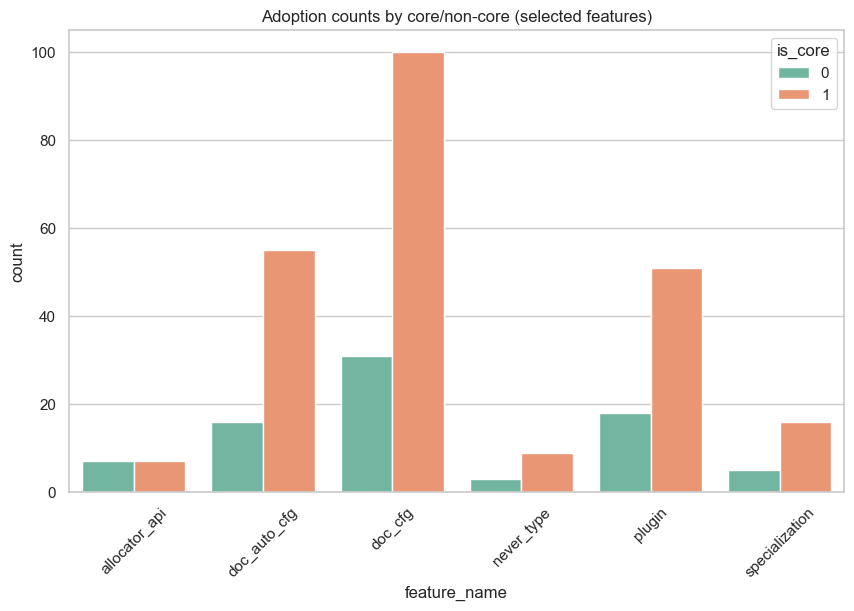

/var/folders/ys/l5n5p6z52jqfj7qhnknsgwhh0000gn/T/ipykernel_14589/631073858.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_cat, x="count", y="top_category", palette="Blues_r")


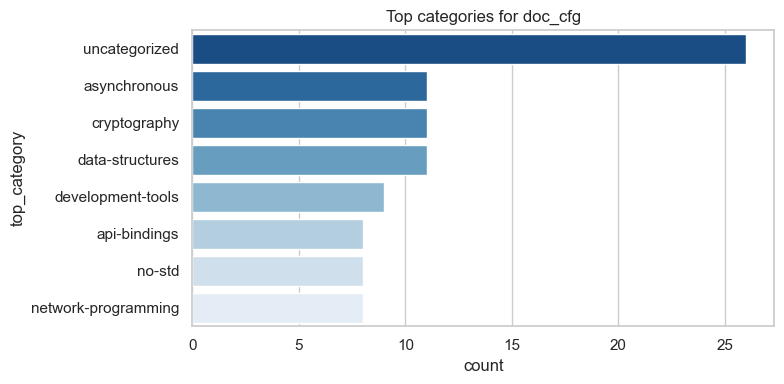

/var/folders/ys/l5n5p6z52jqfj7qhnknsgwhh0000gn/T/ipykernel_14589/631073858.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_cat, x="count", y="top_category", palette="Blues_r")


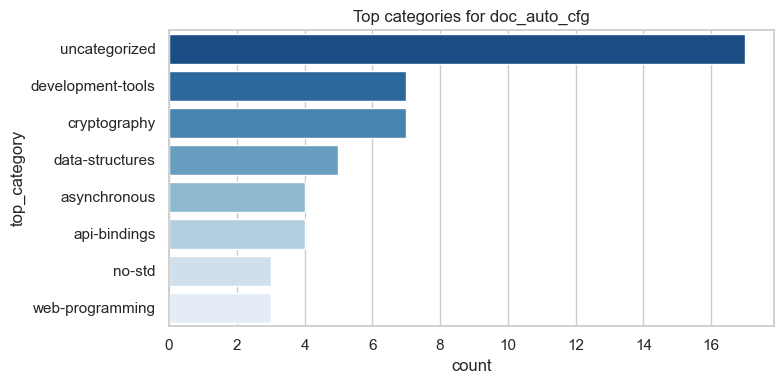

/var/folders/ys/l5n5p6z52jqfj7qhnknsgwhh0000gn/T/ipykernel_14589/631073858.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_cat, x="count", y="top_category", palette="Blues_r")


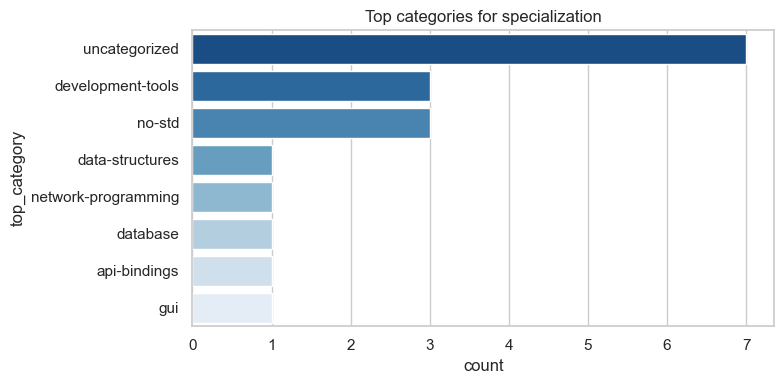

/var/folders/ys/l5n5p6z52jqfj7qhnknsgwhh0000gn/T/ipykernel_14589/631073858.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_cat, x="count", y="top_category", palette="Blues_r")


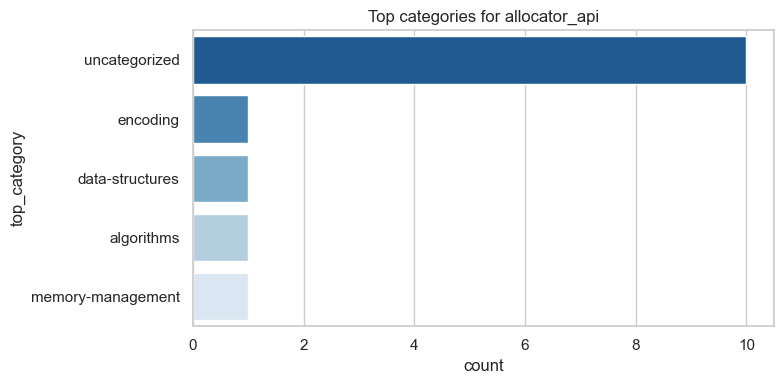

/var/folders/ys/l5n5p6z52jqfj7qhnknsgwhh0000gn/T/ipykernel_14589/631073858.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_cat, x="count", y="top_category", palette="Blues_r")


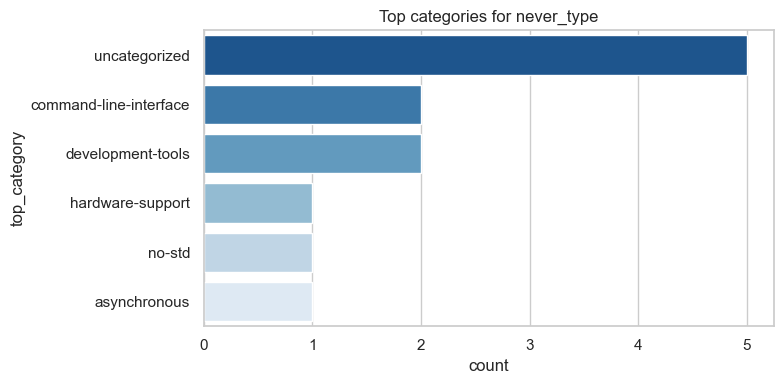

/var/folders/ys/l5n5p6z52jqfj7qhnknsgwhh0000gn/T/ipykernel_14589/631073858.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_cat, x="count", y="top_category", palette="Blues_r")


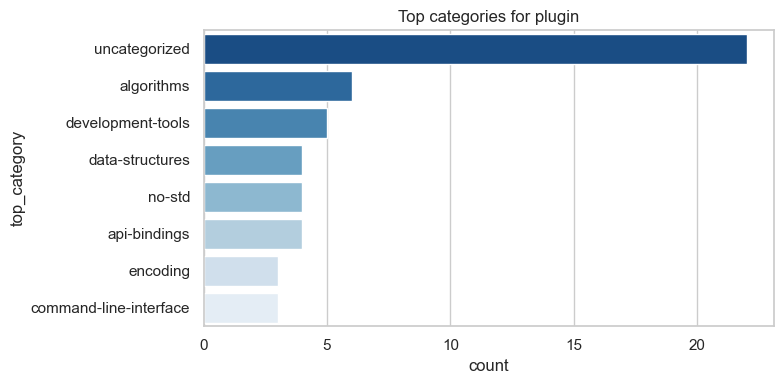

In [9]:
def load_repos(conn):
    r = pd.read_sql_query("SELECT key, is_core, top_categories, downloads_sum, revdeps_sum FROM repos", conn)
    r["is_core"] = r["is_core"].fillna(0).astype(int)
    return r

if conn is not None:
    repos_df = load_repos(conn)
    hist_sel = load_history(conn, selected)
    if not hist_sel.empty:
        merged = hist_sel.merge(repos_df, on="key", how="left")
        merged["top_cat_primary"] = merged["top_categories"].fillna("").apply(lambda s: s.split(",")[0] if s else "uncategorized")
        # core vs non-core counts per feature
        core_counts = merged.groupby(["feature_name", "is_core"]).size().reset_index(name="count")
        plt.figure(figsize=(10,6))
        sns.barplot(data=core_counts, x="feature_name", y="count", hue="is_core", palette="Set2")
        plt.title("Adoption counts by core/non-core (selected features)")
        plt.xticks(rotation=45)
        plt.show()

        # category view (top 8 per feature)
        for feat in selected:
            sub = merged[merged["feature_name"] == feat]
            top_cat = sub["top_cat_primary"].value_counts().head(8).reset_index()
            top_cat.columns = ["top_category", "count"]
            plt.figure(figsize=(8,4))
            sns.barplot(data=top_cat, x="count", y="top_category", palette="Blues_r")
            plt.title(f"Top categories for {feat}")
            plt.tight_layout()
            plt.show()
    else:
        print("No history data for selected features.")
else:
    print("DB not available; skip core/category analysis.")

## 11) Pressure indicators for unstable gates
- For unstable gates (no stable date): look at adoption level, growth, and retention.
- Use current `still_present` counts and cumulative adoption.

In [ ]:
import pandas as pd
import numpy as np
import sqlite3
from pathlib import Path

# --- 路径配置 ---
TIMELINE_CSV = Path("feature_timeline.csv") 
DB_PATH = Path("features_head_v3.db")

def prepare_impact_data(conn, timeline_path):
    # 1. 加载 Feature 生命周期时间表
    if not timeline_path.exists():
        print(f"Error: {timeline_path} not found. Please check file location.")
        return None, None
    
    # 读取 CSV
    timeline = pd.read_csv(timeline_path)
    
    # 标准化列名
    if "feature" in timeline.columns:
        timeline.rename(columns={"feature": "feature_name"}, inplace=True)
    
    # 检查关键列
    if "feature_name" not in timeline.columns or "stabilized_date" not in timeline.columns:
        print("Error: CSV missing 'feature' or 'stabilized_date' columns.")
        return None, None

    # --- 【关键修复】统一日期格式 ---
    # 1. utc=True: 强制解析为 UTC (处理混合格式)
    # 2. .dt.tz_localize(None): 移除时区信息，变为 naive datetime，避免相减报错
    timeline["stabilized_date"] = pd.to_datetime(timeline["stabilized_date"], errors="coerce", utc=True).dt.tz_localize(None)
    
    # 只保留有转正日期的
    stable_features = timeline.dropna(subset=["stabilized_date"]).copy()
    
    print(f"Loaded timeline: {len(timeline)} rows. Valid stabilized features: {len(stable_features)}")

    # 2. 从 DB 加载使用记录
    target_feats = stable_features["feature_name"].unique().tolist()
    
    if not target_feats:
        print("No stabilized features found.")
        return None, None

    placeholders = ",".join(["?"] * len(target_feats))
    query = f"""
        SELECT h.feature_name, h.key as repo_key, h.first_seen_date, r.is_core
        FROM repo_feature_history h
        LEFT JOIN repos r ON h.key = r.key
        WHERE h.feature_name IN ({placeholders})
    """
    
    print("Querying database for history...")
    history = pd.read_sql_query(query, conn, params=target_feats)
    
    # --- 【关键修复】统一日期格式 ---
    # 同样处理 history 中的日期，确保与 timeline 格式一致
    history["first_seen_date"] = pd.to_datetime(history["first_seen_date"], errors="coerce", utc=True).dt.tz_localize(None)
    
    if history.empty:
        print("No history data found.")
        return None, None

    # 3. 合并数据并计算相对时间
    merged = history.merge(stable_features[["feature_name", "stabilized_date"]], on="feature_name", how="inner")
    
    # 现在两者都是 naive datetime，可以直接相减
    merged["days_relative"] = (merged["first_seen_date"] - merged["stabilized_date"]).dt.days
    
    # 标记分类
    merged["adoption_type"] = np.where(merged["days_relative"] < 0, "Early Adopter (Unstable)", "Stable Adopter")
    
    # 4. 计算指标
    impact_summary = merged.groupby("feature_name").agg(
        stabilized_date=("stabilized_date", "first"),
        total_repos=("repo_key", "nunique"),
        pre_stable_count=("adoption_type", lambda x: (x == "Early Adopter (Unstable)").sum()),
        post_stable_count=("adoption_type", lambda x: (x == "Stable Adopter").sum())
    ).reset_index()
    
    impact_summary["pre_stable_ratio"] = impact_summary["pre_stable_count"] / impact_summary["total_repos"]
    
    return merged, impact_summary

# 执行处理
impact_df = None
summary_df = None

if conn is not None:
    impact_df, summary_df = prepare_impact_data(conn, TIMELINE_CSV)
    
    if summary_df is not None:
        print("\n--- Top 5 Features by Total Adoption (Stabilized Only) ---")
        display(summary_df.sort_values("total_repos", ascending=False).head(5))
        
        print("\n--- Top 5 'De-facto Standard' Features (High Pre-stable Usage) ---")
        popular_unstable = summary_df[summary_df["total_repos"] > 10]
        if not popular_unstable.empty:
            display(popular_unstable.sort_values("pre_stable_ratio", ascending=False).head(5))
    else:
        print("Could not generate summary.")
else:
    print("DB connection missing.")

Loaded timeline: 536 total rows.
Features with valid stabilized_date: 204
Querying database for history...


TypeError: Cannot subtract tz-naive and tz-aware datetime-like objects

## 12) Build wide tables (repo×feature and feature-level)

Wide A: repo × feature with repo attributes, feature timeline, pre/post-stable flags.
Wide B: feature-level aggregation with adoption signals and timelines.


In [11]:
def plot_stabilization_impact(impact_df, summary_df, top_n=6):
    """
    绘制以转正日(T=0)为中心的累计采用曲线。
    旨在直观展示 Feature 转正是否导致了采用率的拐点。
    """
    if impact_df is None or impact_df.empty:
        print("No data available for plotting.")
        return

    # 选取总使用量最大的 N 个 Feature 进行展示
    top_features = summary_df.sort_values("total_repos", ascending=False).head(top_n)["feature_name"].tolist()
    
    # 设置绘图网格
    cols = 2
    rows = (len(top_features) + 1) // 2
    fig, axes = plt.subplots(rows, cols, figsize=(15, 4 * rows))
    axes = axes.flatten()
    
    for i, feat in enumerate(top_features):
        ax = axes[i]
        subset = impact_df[impact_df["feature_name"] == feat].copy()
        
        # 排序并计算累计数量
        subset = subset.sort_values("days_relative")
        
        # 为了画出阶梯图，我们需要构建累计计数
        # 使用 groupby 天数来减少点数，提高绘图效率
        daily_counts = subset.groupby("days_relative").size().reset_index(name="new_users")
        daily_counts["cumulative_users"] = daily_counts["new_users"].cumsum()
        
        # 获取转正日期用于标题
        stable_date = subset["stabilized_date"].iloc[0].strftime("%Y-%m-%d")
        
        # --- 核心绘图 ---
        # 1. 画累计曲线
        sns.lineplot(data=daily_counts, x="days_relative", y="cumulative_users", ax=ax, linewidth=2.5, color="#2c3e50")
        
        # 2. 填充区域 - 区分 Pre-stable 和 Post-stable
        # 获取 Pre 部分的数据
        pre_data = daily_counts[daily_counts["days_relative"] <= 0]
        if not pre_data.empty:
            ax.fill_between(pre_data["days_relative"], 0, pre_data["cumulative_users"], color="#e74c3c", alpha=0.15, label="Pre-stable Phase")
            
        # 获取 Post 部分的数据
        post_data = daily_counts[daily_counts["days_relative"] > 0]
        if not post_data.empty:
            ax.fill_between(post_data["days_relative"], 0, post_data["cumulative_users"], color="#27ae60", alpha=0.15, label="Post-stable Phase")
        
        # 3. 添加 T=0 的参考线
        ax.axvline(0, color="red", linestyle="--", linewidth=1.5, label="Stabilization Event")
        
        # 4. 标注 Core/Non-Core 的分布 (可选，在图例中文字说明)
        core_ratio = subset[subset["is_core"] == 1].shape[0] / len(subset) if len(subset) > 0 else 0
        
        # 装饰
        ax.set_title(f"Feature: {feat}\nStabilized: {stable_date} (Core Ratio: {core_ratio:.1%})", fontsize=11, fontweight='bold')
        ax.set_xlabel("Days Relative to Stabilization (0 = Stabilized)")
        ax.set_ylabel("Cumulative Repos Using Feature")
        ax.grid(True, linestyle=":", alpha=0.6)
        
        # 设置 X 轴范围，聚焦在转正前后一年 (如有数据支持)
        min_day = max(daily_counts["days_relative"].min(), -730) # 最多看前2年
        max_day = min(daily_counts["days_relative"].max(), 730)  # 最多看后2年
        ax.set_xlim(min_day, max_day)
        
        if i == 0:
            ax.legend(loc="upper left")

    # 隐藏多余的子图
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
        
    plt.tight_layout()
    plt.show()

# 执行绘图
if summary_df is not None:
    print("正在生成可视化：转正前后的采用趋势对比...")
    # 这里选择 Top 8 最热门的已转正 Feature 进行展示
    plot_stabilization_impact(impact_df, summary_df, top_n=8)
else:
    print("无法绘图，数据缺失。")

无法绘图，数据缺失。
